<a href="https://colab.research.google.com/github/azmihasan/CoverViolence/blob/main/CoverViolence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connect to Google Drive
if you don't want use a google drive, it will also be working.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from moviepy.editor import *
import numpy as np
from matplotlib import pyplot as plt

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2236416/45929032 bytes (4.9%)5545984/45929032 bytes (12.1%)8888320/45929032 bytes (19.4%)11968512/45929032 bytes (26.1%)15376384/45929032 bytes (33.5%)18866176/45929032 bytes (41.1%)22290432/45929032 bytes (48.5%)25796608/45929032 bytes (56.2%)29106176/45929032 bytes (63.4%)32612352/45929032 bytes (71.0%)35913728/45929032 bytes (78.2%)39387136/45929032 bytes (85.8%)

#Preprocessing

To allocate the movie-Path-Directory

Please upload the video file first and paste the path.

In [ ]:
movie_path = '/content/drive/MyDrive/CoverViolence/movie/fighting_trailer.mp4'
frames = []
file = VideoFileClip(movie_path)
duration = file.duration
print(duration)

151.07


#Processing the RGB values to Color Histogram


In [ ]:
def Histogram_Computation(Image):
    Image_Height = Image.shape[0]
    Image_Width = Image.shape[1]
    Image_Channels = Image.shape[2]
    print('H:', str(Image_Height), 'W: ', Image_Width, 'C: ', Image_Channels)

    Histogram = np.zeros([256, Image_Channels], np.int32)

    for x in range(0, Image_Height):
        for y in range(0, Image_Width):
            for c in range(0, Image_Channels):
                Histogram[Image[x, y, c], c] += 1
    
    return Histogram

In [ ]:
def Plot_Histogram(Histogram):
    plt.figure()
    plt.title("Color Image Histogram")
    plt.xlabel("Intensity Level")
    plt.ylabel("Intensity Frequency")
    plt.xlim([0, 256])
    plt.plot(Histogram[:, 0], 'b')  # This is to Plot Blue Channel with Blue Color
    plt.plot(Histogram[:, 1], 'g')  # This is to Plot Green Channel with Green Color
    plt.plot(Histogram[:, 2], 'r')  # This is to Plot Red Channel with Red Color
    plt.show()

In [ ]:
def frameInput(Input_Image):
    Histogram = Histogram_Computation(Input_Image)
    '''
    for i in range(0, Histogram.shape[0]):
        for c in range(0, Histogram.shape[1]):
            print("Histogram[", i, ", ", c, "]: ", Histogram[i, c])
    '''

    return Histogram

#Extract the choosen frames depend on the framerate / frame per second.

In [ ]:
for i in file.iter_frames(fps=0.1, with_times=True): # fps = 0.1 every 10 seconds a frame will be extracted
  data = {
      'time' : i[0],
      'frame' : i[1],
      'histogram' : frameInput(i[1])
  }
  frames.append(data)


H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3
H: 692 W:  1280 C:  3


#Showing the frames

0


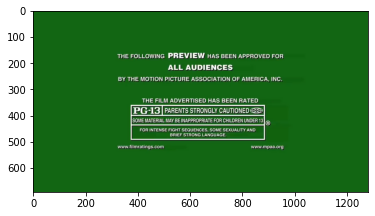

1


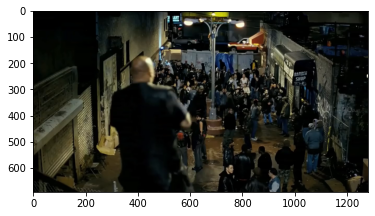

2


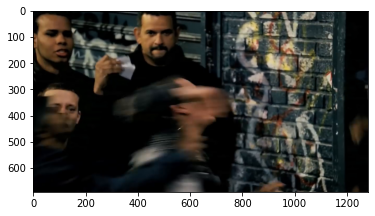

3


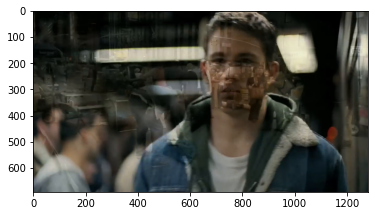

4


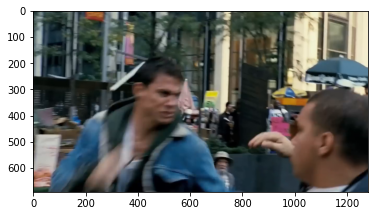

5


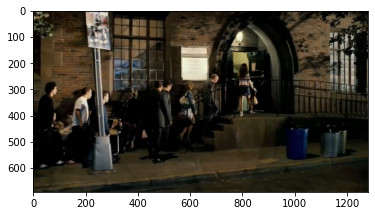

6


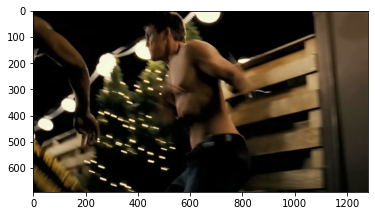

7


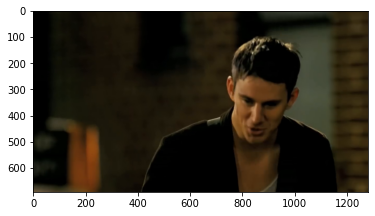

8


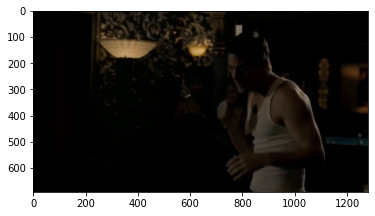

9


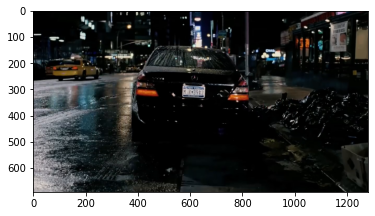

10


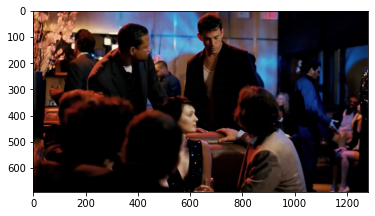

11


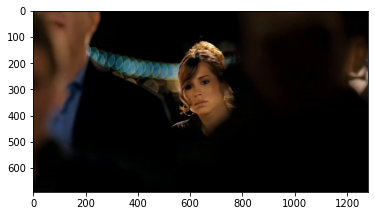

12


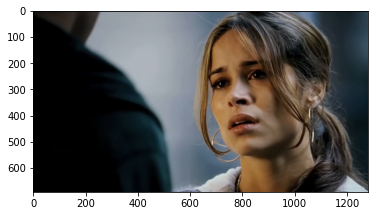

13


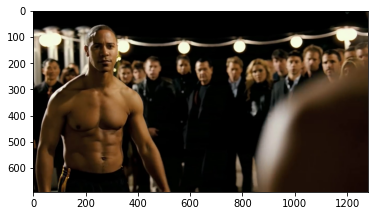

14


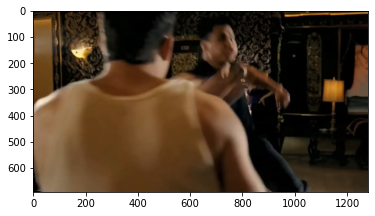

15


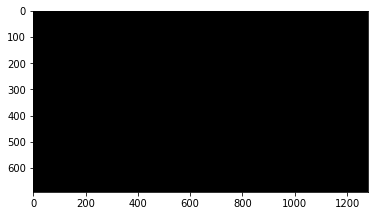

In [ ]:


for a,i in enumerate(frames):
  print(a)
  frame = i['frame']
  plt.imshow(frame)
  plt.show()



#Collecting all RGB-Values into one array

In [ ]:
b_h = []
g_h = []
r_h = []
for i in frames:
  b_h.append(max(i['histogram'][:, 0]))
  g_h.append(max(i['histogram'][:, 1]))
  r_h.append(max(i['histogram'][:, 2]))

#The whole RGB-Value for a video

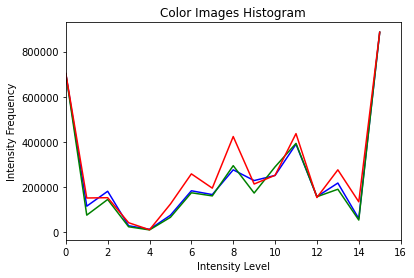

In [ ]:
plt.figure()
plt.title("Color Images Histogram")
plt.xlabel("Intensity Level")
plt.ylabel("Intensity Frequency")
plt.xlim([0, len(b_h)])
plt.plot(b_h, 'b')  # This is to Plot Blue Channel with Blue Color
plt.plot(g_h, 'g')  # This is to Plot Green Channel with Green Color
plt.plot(r_h, 'r')  # This is to Plot Red Channel with Red Color
plt.show()

# To use Saliency Model, we must change the frame data to PIL-Image

In [ ]:
from PIL import Image

pil_images = []

for i in frames:
  data = {
      'time' : i['time'],
      'PIL' : Image.fromarray(i['frame'])
  }
  pil_images.append(data)

#In this section, we implement method to estimate the saliency map of each frame

In [ ]:

import torch
import torchvision
import torchvision.transforms as T

def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
def saliencyMapping(model, img):
  X = preprocess(img)
  model.eval()
  X.requires_grad_()
  scores = model(X)
  score_max_index = scores.argmax()
  score_max = scores[0,score_max_index]
  score_max.backward()
  saliency, value = torch.max(X.grad.data.abs(),dim=1)
  plt.imshow(saliency[0])
  plt.show()
  return saliency, value


#Showing the saliency map of each PIL-Image

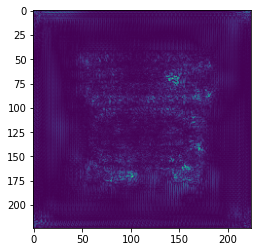

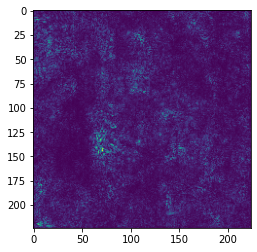

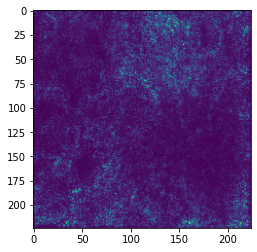

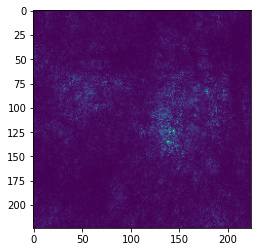

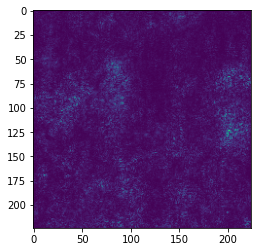

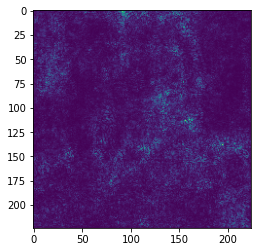

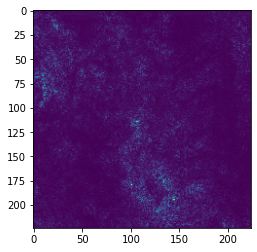

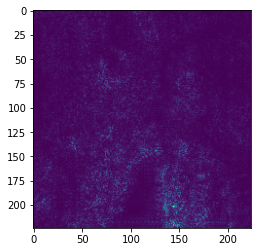

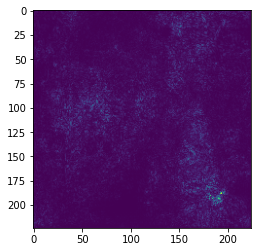

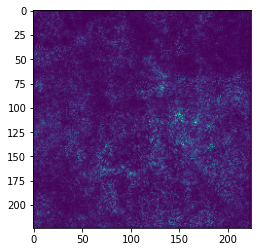

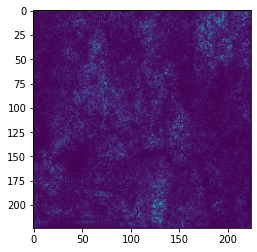

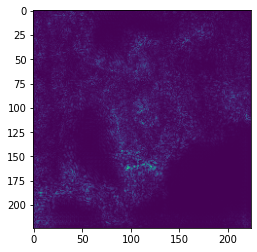

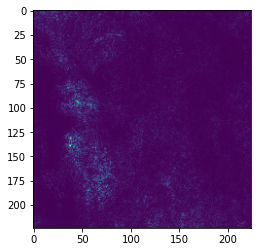

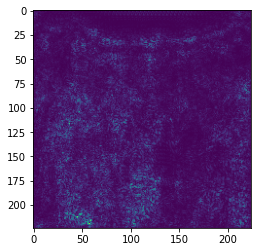

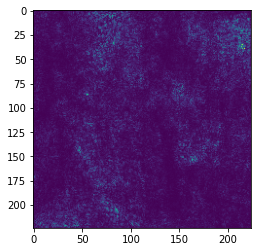

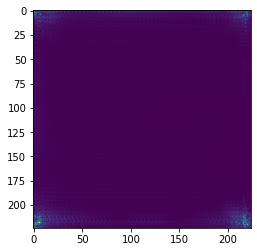

In [ ]:
sal_images = []

for i in pil_images:
  saliency, value = saliencyMapping(model,i['PIL']) 
  data = {
      'time' : i['time'],
      'PIL' : i['PIL'],
      'value' : value,
      'saliency' : saliency
  }
  sal_images.append(data)
  

In [ ]:
!pip install cv

0.7843989158163265


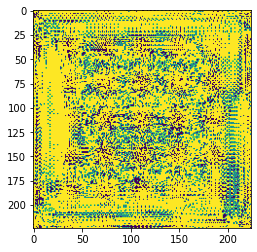

0.7501195790816326


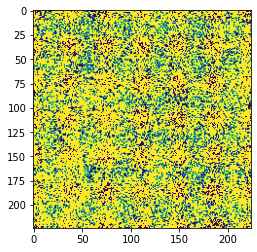

0.7374043367346939


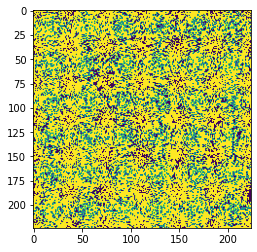

0.7541254783163265


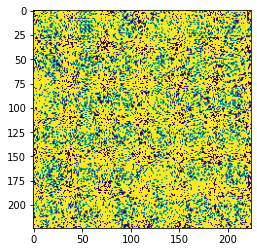

0.7784996811224489


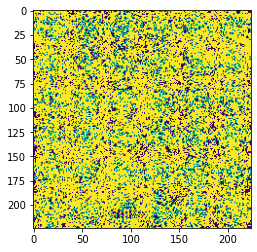

0.7677574936224489


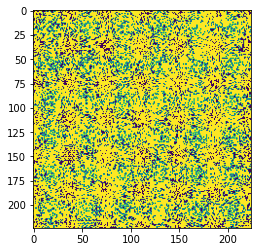

0.7535674426020408


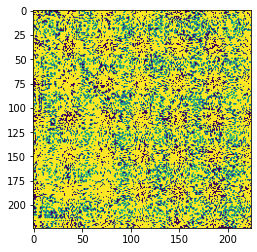

0.7466517857142857


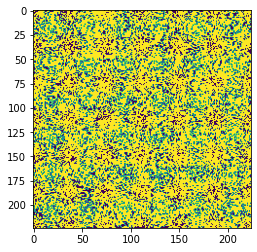

In [ ]:

import cv2
nonzero_counts = []
for i in sal_images:
  value = i['value'][0].numpy()
  nonzero = cv2.countNonZero(value) 
  total = value.shape[0] * value.shape[1]
  formula = nonzero / total
  print(formula)  
  pil = Image.fromarray((value * 255).astype(np.uint8))
  plt.imshow(pil)
  plt.show()
  if formula >= 0.5:
    sal_images.remove(i)

#Load Trainned Model or Training Phase

We already trained our model from this script: https://colab.research.google.com/drive/1lkiHd5jqU5se-6LiXh0pBML_v3usvXNz?usp=sharing

If you use "GPU", please add Image.cuda()



In [ ]:
load = torch.load('/content/drive/MyDrive/CoverViolence/mobilenetv2/mobilenetv2_model_best_checkpoint.pth')

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
model = models.mobilenet_v2(pretrained=True)
model.load_state_dict(load['model'])

<All keys matched successfully>

#Implementing classification method for each image

In [ ]:
import torchvision.transforms as transforms
classes = ['safe', 'unsafe']
mean = [0.4014, 0.3769, 0.3608]
std = [0.2224, 0.2138, 0.2114]

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

def classify(model, image_transforms, pil_image, classes):
  model.eval()
  if torch.cuda.is_available():
    model.cuda()
  image = pil_image
  image = image_transforms(image)
  image = image.cuda() # if you use 'GPU', if no just add hashtag
  image = image.unsqueeze(0)
  output = model(image)
  _, predicted = torch.max(output.data, 1)
  plt.imshow(pil_image)
  plt.show()
  result = classes[predicted.item()]
  print(classes[predicted.item()])
  return result


#Showing all images with their classification

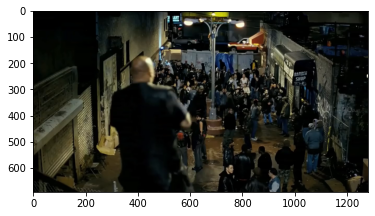

unsafe


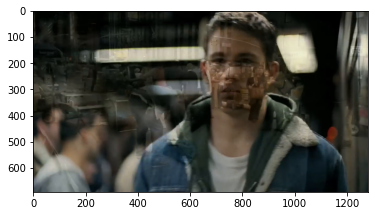

unsafe


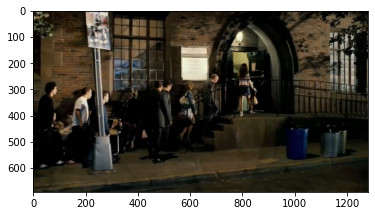

unsafe


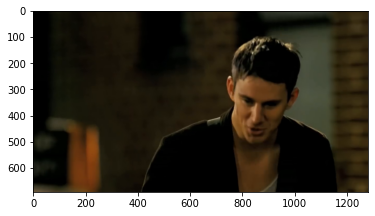

unsafe


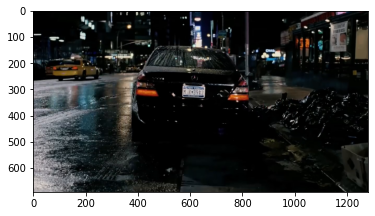

unsafe


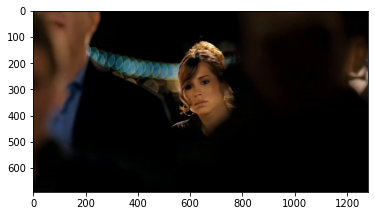

safe


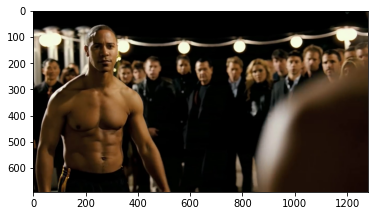

unsafe


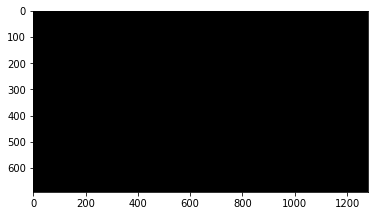

safe


In [ ]:
result = []
for i in sal_images:
  data = {
        'time' : i['time'],
        'classify' : classify(model, image_transforms, i['PIL'], classes)
  }
  result.append(data)

#Post Processing

In this section, we collect all safe image and use the related time to produce a new video

In [ ]:
cutout = []
for i in result:
  if i['classify'] == 'safe':
    start = i['time'] - 5
    end = i['time'] + 5
    if start < 0 :
      start = 0
    if end > duration:
      end = duration
    if start >= 0 :
      data = {
          'start' : start,
          'end' : end
      }
      cutout.append(data)

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip as subclip

for a, i in enumerate(cutout):
  path = '/content/drive/MyDrive/CoverViolence/movie/new movie/fighting_trailer_'+ str(a)+'.mp4'
  subclip(movie_path, i['start'], i['end'], path)



[MoviePy] Running:
>>> /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -y -i /content/drive/MyDrive/CoverViolence/movie/fighting_trailer.mp4 -ss 105.00 -t 10.00 -vcodec copy -acodec copy /content/drive/MyDrive/CoverViolence/movie/new movie/fighting_trailer_0.mp4
... command successful.

[MoviePy] Running:
>>> /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -y -i /content/drive/MyDrive/CoverViolence/movie/fighting_trailer.mp4 -ss 145.00 -t 6.07 -vcodec copy -acodec copy /content/drive/MyDrive/CoverViolence/movie/new movie/fighting_trailer_1.mp4
... command successful.


In [ ]:
clips = []
for i in range(len(cutout)):
  path = '/content/drive/MyDrive/CoverViolence/movie/new movie/fighting_trailer_'+ str(i)+'.mp4'
  clip = VideoFileClip(path)
  clips.append(clip)

final = concatenate_videoclips(clips)


In [ ]:
final.write_videofile('/content/drive/MyDrive/CoverViolence/movie/new movie/new_fighting_trailer_.mp4')

[MoviePy] >>>> Building video /content/drive/MyDrive/CoverViolence/movie/new movie/new_fighting_trailer_.mp4
[MoviePy] Writing audio in new_fighting_trailer_TEMP_MPY_wvf_snd.mp3


100%|██████████| 355/355 [00:00<00:00, 703.26it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/CoverViolence/movie/new movie/new_fighting_trailer_.mp4



100%|██████████| 386/386 [00:13<00:00, 29.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/CoverViolence/movie/new movie/new_fighting_trailer_.mp4 

